In [1]:
import argparse
import os
import warnings
import yaml
import sys
sys.path.append('/home/pasti/PycharmProjects/Robot_CLOD/')

import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.accelerators import find_usable_cuda_devices
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from nanodet.data.collate import naive_collate
from nanodet.data.dataset import build_dataset
from nanodet.evaluator import build_evaluator
from nanodet.trainer.task import TrainingTask
from nanodet.trainer.latent_dist_task import LatentDistTrainingTask
from torchvision.transforms import ToTensor, ToPILImage
from nanodet.util import (
    NanoDetLightningLogger,
    cfg,
    convert_old_model,
    env_utils,
    load_config,
    load_model_weight,
    mkdir,
)
from tools.inference import Predictor


In [2]:
load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/domain1task1.yml')
logger = NanoDetLightningLogger('test')
nanodet = Predictor(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/models/domain1task1/model_last.ckpt', logger)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/domain1task1.yml'

In [ ]:
import glob
folder_path = '/home/pasti/PycharmProjects/GroundingDINO/.asset/Dataset/Domain 1/Low/val'
image_files = glob.glob(folder_path + '/*.png')
for str_image in image_files:
    meta, dets = nanodet.inference(str_image)
    nanodet.visualize(dets, meta, cfg.data.train.exp_names, 0.3)
    break


In [3]:
load_config(cfg, '/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/cREP_noaugtask1.yml')
train_dataset = build_dataset(cfg.data.train, "train")
print(len(train_dataset))
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=cfg.device.workers_per_gpu,
    pin_memory=True,
    collate_fn=naive_collate,
    drop_last=True,
)

val_dataset = build_dataset(cfg.data.val, "val")
print(len(val_dataset))

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=cfg.device.workers_per_gpu,
    pin_memory=True,
    collate_fn=naive_collate,
    drop_last=False,
)
evaluator = build_evaluator(cfg.evaluator, val_dataset)

TrainTask = TrainingTask(cfg, evaluator)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
732
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
91
model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.


['d1_h_frame1.png']


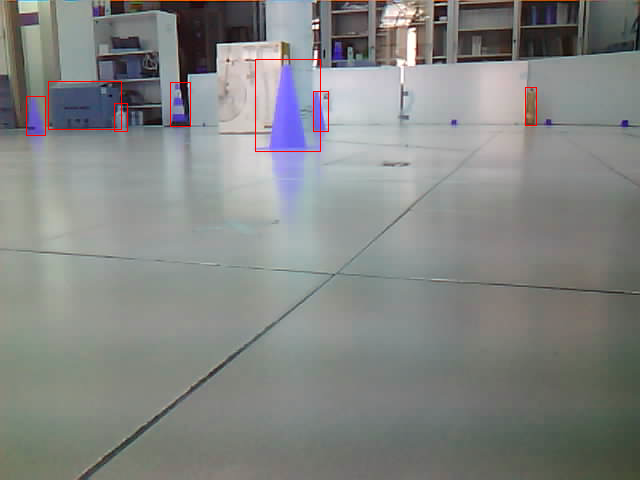

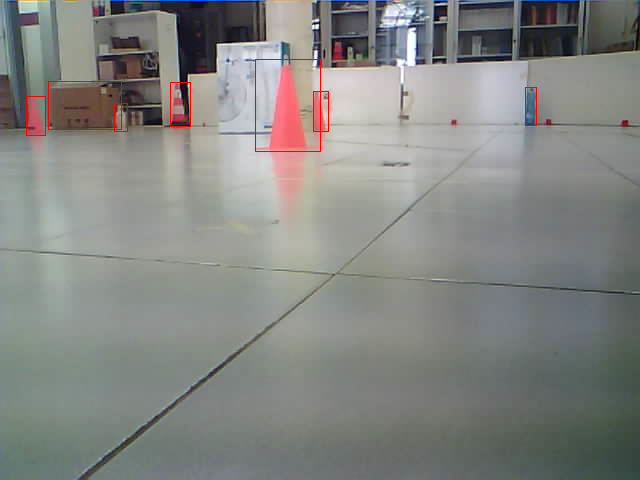

In [4]:
from IPython.display import display
from PIL import ImageDraw
from PIL import Image

for batch in train_dataloader:
    batch = TrainTask._preprocess_batch_input(batch)
    i = 0
    print(batch['img_info']['file_name'])
    for img in batch['img']:
        imgPil = ToPILImage()(batch['img'][i])

        imgPath = '/home/pasti/Dataset/TiROD/Domain1/High/images/train/' + str(batch['img_info']['file_name'][i])
        imgPath = Image.open(imgPath)
        draw = ImageDraw.Draw(imgPil)
        drawOrig = ImageDraw.Draw(imgPath)

        for box in batch['gt_bboxes'][i]:
            draw.rectangle([box[0], box[1], box[2], box[3]], outline='red')
            drawOrig.rectangle([box[0], box[1], box[2], box[3]], outline='red')
        display(imgPil)
        display(imgPath)
        
        i += 1
    break